<a href="https://colab.research.google.com/github/HollowMike8/bounding-box-regression-keras/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! git
! git init

In [ ]:
!git clone https://github.com/HollowMike8/bounding-box-regression-keras.git

Cloning into 'bounding-box-regression-keras'...
remote: Enumerating objects: 828, done.
remote: Counting objects: 100% (828/828), done.
remote: Compressing objects: 100% (824/824), done.
remote: Total 828 (delta 8), reused 814 (delta 2), pack-reused 0
Receiving objects: 100% (828/828), 7.18 MiB | 8.55 MiB/s, done.
Resolving deltas: 100% (8/8), done.


In [ ]:
%cd bounding-box-regression-keras/

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow.keras.layers as tfl
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array

In [ ]:
path_dir: str = r"/content/bounding-box-regression-keras"

import sys
sys.path.insert(0,path_dir)
from pyimagesearch import config

In [ ]:
# load the contents of the CSV annotations file
csv_path = os.path.join(path_dir,'dataset', 'airplanes.csv')
rows = open(csv_path, "r").read().strip().split("\n")

# initialize the list of data (images), bounding box coordinates, filenames
data = []
targets = []
filenames = []

# loop over rows and append data in corresponding lists
for row in rows:
  row = row.split(",")
  filename, startX, startY, endX, endY = row

  image_path = os.path.join(config.images_path, filename)
  image = cv2.imread(image_path)
  (h, w) = image.shape[:2]

  startX = float(startX) / w
  startY = float(startY) / h
  endX = float(endX) / w
  endY = float(endY) / h

  image = load_img(image_path, target_size=(224, 224))
  image = img_to_array(image)

  data.append(image)
  targets.append((startX, startY, endX, endY))
  filenames.append(filename)

In [ ]:
# convert the data and targets to NumPy arrays and scale the data
data = np.array(data, dtype = "float32")/255
targets = np.array(targets, dtype = "float32")

# train, test split
split = train_test_split(data, targets, filenames, test_size = 0.10, 
                         random_state=42)

# extract the training and testing data
(train_images, test_images) = split[:2]
(train_targets, test_targets) = split[2:4]
(trainFilenames, testFilenames) = split[4:]

In [ ]:
# write the test filenames
print("[INFO] saving test filenames...")
f = open(config.test_filenames, "w")
f.write("\n".join(testFilenames))
f.close()

[INFO] saving test filenames...


In [ ]:
# load the VGG16 model excluding the last three FC Dense layers and w/o training
vgg = VGG16(weights="imagenet", include_top=False, 
            input_tensor=tfl.Input(shape=(224, 224, 3)))
vgg.trainable = False

# flatten the max-pooling output of VGG16
flatten = tfl.Flatten()(vgg.output)

# FC layers with output size as 4 to predict bounding box coordinates
bboxHead = tfl.Dense(128, activation="relu")(flatten)
bboxHead = tfl.Dense(64, activation="relu")(bboxHead)
bboxHead = tfl.Dense(32, activation="relu")(bboxHead)
bboxHead = tfl.Dense(4, activation="sigmoid")(bboxHead)

# model
model = Model(inputs=vgg.input, outputs=bboxHead)
opt = Adam(learning_rate = config.alpha)
model.compile(loss="mse", optimizer=opt)
print(model.summary())

In [ ]:
# train the model
H = model.fit(train_images, train_targets, 
              validation_data=(test_images, test_targets), 
              batch_size=config.batch_size, epochs=config.epochs, verbose=1)
print("[INFO] training bounding box regressor --> FINISHED")

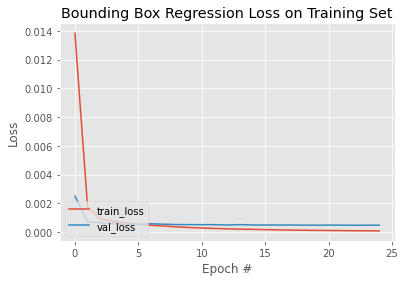

In [ ]:
# save the model
model.save(config.model_path, save_format="h5")

# plot the model training history
N = config.epochs
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Bounding Box Regression Loss on Training Set")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(config.plot_path)